# simplethermodynamics

A demonstration of the core features of the package: defining Phases, packing them into Compounds, and assembling ThermodynamicDatabases.

In [1]:
try:
    # if the package has already been installed
    from simplethermodynamics import Phase, Compound, ThermodynamicDatabase
except ModuleNotFoundError:
    try:
        # if not installed and the examples are running from the package folder
        import sys
        sys.path.append('..')
        from simplethermodynamics import Phase, Compound, ThermodynamicDatabase
    except ModuleNotFoundError:
        try:
            # if the examples are running in Google Colab
            import google.colab
            !pip install "simplethermodynamics @ git+https://github.com/voffch/simplethermodynamics@master"
            from simplethermodynamics import Phase, Compound, ThermodynamicDatabase
        except:
            # this shouldn't happen, so print the error message
            print("Cannot import simplethermodynamics; check the package installation and this file's path", 
                  file=sys.stderr)

In [2]:
from sympy import Symbol, log, Piecewise
import numpy as np

## Basic example: a couple of Phases and a Compound

The Gibbs functions for Fe for this example were calculated from the [Gurvich tables](http://www.chem.msu.su/rus/tsiv/Fe/welcome.html) (Thermodynamic properties of individual substances).

Note that here, as in the original data, solid and liquid phases are defined together as one "condensed" phase.

In [3]:
# defining the Phases
# Gibbs function as a string
fe_sl = Phase('solid,liquid', 'solid,liquid', g='-T*Piecewise((9.166e-9*T**3 - 3.17643333333e-5*T**2 + 0.0685965*T - 6.749*log(0.0001*T) - 20.5578483453 - 3369.02213525/T + 220950.0/T**2, (T >= 298.15) & (T < 800.0)), (1.91742608333e-6*T**3 - 0.0125532551667*T**2 + 43.8405795*T - 38217.381*log(0.0001*T) - 105954.823394 - 16661850.0395/T + 1450984000.0/T**2, T < 1042.0), (-0.00217531033333*T**2 + 19.804755*T - 33783.834*log(0.0001*T) - 73362.2636102 - 25681081.3856/T + 3661585750.0/T**2, T < 1184.0), (0.004142*T + 24.267*log(0.0001*T) + 93.7664837826 - 4538.384448/T, T < 1665.0), (0.005021*T + 24.393*log(0.0001*T) + 91.4437916719 - 2732.313275/T, T < 1809.0), (46.0*log(0.0001*T) + 132.575174684 + 6123.0/T, T < 5000.0), (0, True)) - 4506.0')
# Gibbs function as a SymPy expression
T = Symbol('T')
fe_g_g = -T*Piecewise((-2.70719177246e-10*T**3 + 2.55359771729e-6*T**2 - 0.0118340270996*T + 34.3188095093*log(0.0001*T) + 271.590881348 + 3310.39130688/T - 127031.374723/T**2, (T >= 298.15) & (T < 1500.0)), (-6.07623386383e-12*T**3 + 1.90518684387e-7*T**2 - 0.000907385253906*T + 23.4647369385*log(0.0001*T) + 241.031799316 + 936.141014099/T - 1062649.48845/T**2, T < 10000.0), (0, True)) + 407150.0
fe_g = Phase('gas', 'gas', g=fe_g_g)

In [4]:
# defining the Compound
# takes some time because of the phase transition data calculations
fe = Compound('iron', [fe_sl, fe_g], 'Gurvich')
print(fe)

Compound 'iron' contains 2 phases: solid,liquid (solid,liquid), gas (gas)


In [5]:
fe.transitions

[{'t': 298.15, 'name': 'solid,liquid'},
 {'t': 3124.7327706443084, 'name': 'gas'}]

In [6]:
# takes some time because different thermodynamic functions of the phases should be calculated
fe.transition_thermodynamics

[{'from': 'solid,liquid',
  'to': 'gas',
  't': 3124.7327706443084,
  't/C': 2851.5827706443083,
  'dh': 348134.1940467397,
  'ds': 111.41246926138624,
  'dcp': -19.486921240777836}]

In [7]:
# takes some time because thermodynamics of the stable phase should be calculated
fe.table()

Compound: iron
Formula: iron
Compound 'iron' contains 2 phases: solid,liquid (solid,liquid), gas (gas)

Standard state transitions at 1 atm (per mol):
____________________	________	________	____________	________	________
               Trans	    T(K)	    T(C)	       ΔH(J)	 ΔS(J/K)	ΔCp(J/K)
____________________	________	________	____________	________	________
 solid,liquid -> gas	 3124.73	 2851.58	    348134.2	 111.412	 -19.487

Phase: stable
State: solid,liquid,gas
________	________	___________	___________	________	___________
  T(K)  	Cp(J/K) 	    H(J)   	   G(J)    	 S(J/K) 	 H-H298(J)
________	________	___________	___________	________	___________
  298.15	  25.100	       -0.0	    -8145.5	  27.320	        0.0
  300.00	  25.136	       46.5	    -8196.1	  27.475	       46.5
  400.00	  27.436	     2672.2	   -11333.1	  35.013	     2672.2
  500.00	  29.718	     5531.4	   -15160.5	  41.384	     5531.4
  600.00	  31.942	     8613.4	   -19584.7	  46.997	     8613.4
  700.00	  34.528	    11931

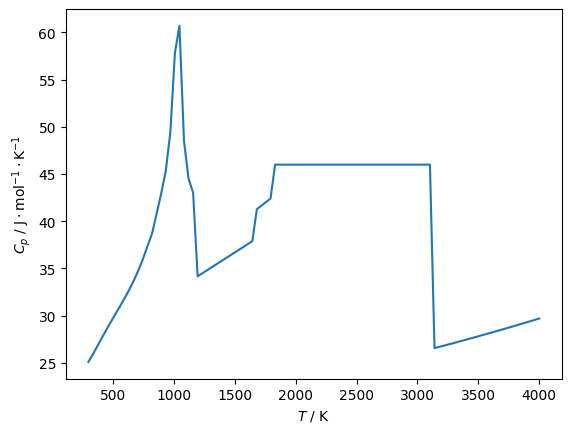

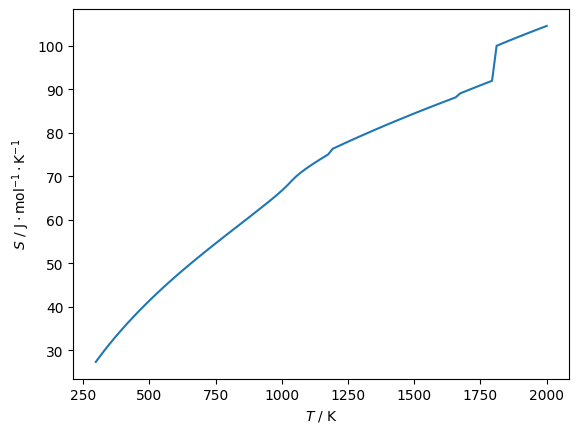

In [8]:
# this is fast because all the necessary thermodynamic functions were calculated already
fe.plot('cp', 298.15, 4000)
fe['solid,liquid'].plot('s', 298.15, 2000)

In [9]:
print(fe['gas'].g(4000), fe['solid,liquid'].g(4000))

-467765.10784466716 -372332.2040711554


## More complex example: creating a small database

In this section, we're making a "database" for the [Thermodynamics of rare earth sesquioxides](https://doi.org/10.1016/j.pmatsci.2006.09.002) from the Gibbs function data presented by Matvei Zinkevich in the referenced paper in Table 6.2.

And then we'll dump the "database" into the JSON file, read it back, and use it in some calculations.

The overall structure of the "database" JSON will look like this:

```json
"compounds" : [{
	"name" : string,
	"formula": string,
	"phases" : [{
		"name" : string,
        "state" : string,
		"g" : string (symbolic string)
		"cp" : string (symbolic string)
        "h" : string (symbolic string)
        "s" : string (symbolic string)
	}],
	"stable" : {
		"name" : "stable",
        "state" : "all",
		"g" : string (symbolic string)
		"cp" : string (symbolic string)
        "h" : string (symbolic string)
        "s" : string (symbolic string)
	}
	"transitions" : [ {"t" : number, "name": string} ],
	"info" : string
}],
"info" : string
```

Note to self: I should probably think about creating a JSON Schema (see [here](https://www.mongodb.com/basics/json-schema-examples) or [here](https://json-schema.org/learn/getting-started-step-by-step.html)) for this thing.

In [10]:
# parsing the data table and extracting the Gibbs function data for the respective phases

def zinkevich_g(a, b, c, d, e, f):
    T = Symbol('T')
    return a + b*T + c*T*log(T) + d*T**2 + e*T**(-1) + f*T**(-2)

zinkevich_table = '''C-Sc2O3	-1955472	751.4893	-120.843	-0.004227	1826000	-5.2e7
C-Y2O3	-1976462	731.6512	-121.881	-0.005060	1090000	-1.3e7
A-La2O3	-1833257	692.9664	-120.629	-0.006854	808000	-1.0e7
A-Ce2O3	-1832858	667.3306	-119.855	-0.012155	546000	0
A-Pr2O3	-1851548	683.3800	-122.780	-0.012360	638000	-1.0e7
A-Nd2O3	-1847329	637.4243	-116.358	-0.014677	711000	-1.0e7
C-Sm2O3	-1875835	780.6356	-135.618	-0.006896	1191000	0
B-Sm2O3	-1871213	751.7711	-132.137	-0.008367	1405000	-4.0e7
C-Eu2O3	-1701762	774.5807	-133.819	-0.009091	667000	0
B-Eu2O3	-1693456	732.3929	-128.827	-0.010086	559000	0
C-Gd2O3	-1868812	660.0623	-119.1688	-0.006438	772000	0
B-Gd2O3	-1858111	620.0992	-114.534	-0.007203	540000	0
C-Tb2O3	-1903004	640.3000	-117.520	-0.012240	250000	0
C-Dy2O3	-1902316	679.1313	-122.593	-0.006971	59000	4.0e7
C-Ho2O3	-1921338	654.7487	-120.347	-0.005998	91000	3.0e7
C-Er2O3	-1939714	652.6562	-119.216	-0.005889	428000	2.0e7
C-Tm2O3	-1927401	680.6164	-121.506	-0.005899	0	4.0e7
C-Yb2O3	-1853511	702.7502	-123.821	-0.004567	0	5.0e7
C-Lu2O3	-1920290	710.2224	-120.356	-0.004579	1144000	-2.0e7'''

zinkevich_oxides = {}
for line in zinkevich_table.splitlines():
    cells = line.split()
    ph, fo = cells[0].split('-') # phase and formula strings
    g = zinkevich_g(*[float(x) for x in cells[1:]])
    if fo in zinkevich_oxides:
        zinkevich_oxides[fo][ph] = Phase(ph, 'solid', g=g)
    else:
        zinkevich_oxides[fo] = {ph : Phase(ph, 'solid', g=g)}

print(len(zinkevich_oxides), 'Oxides parsed')

16 Oxides parsed


In [11]:
# creating the Compound instances from the parsed data and storing them in the database

zinkevich_compounds = {oxide : Compound(oxide, phases) for oxide, phases in zinkevich_oxides.items()}
info = 'Zinkevich, Thermodynamics of rare earth sesquioxides, https://doi.org/10.1016/j.pmatsci.2006.09.002'
db = ThermodynamicDatabase(zinkevich_compounds, info)
db.dump('Zinkevich_R2O3.json')

In [12]:
# reading the database back

db = ThermodynamicDatabase('Zinkevich_R2O3.json')
db.info

'Zinkevich, Thermodynamics of rare earth sesquioxides, https://doi.org/10.1016/j.pmatsci.2006.09.002'

In [13]:
# what compounds and phases are there?

{x : [y for y in db[x].phases] for x in db.compounds}

{'Sc2O3': ['C'],
 'Y2O3': ['C'],
 'La2O3': ['A'],
 'Ce2O3': ['A'],
 'Pr2O3': ['A'],
 'Nd2O3': ['A'],
 'Sm2O3': ['C', 'B'],
 'Eu2O3': ['C', 'B'],
 'Gd2O3': ['C', 'B'],
 'Tb2O3': ['C'],
 'Dy2O3': ['C'],
 'Ho2O3': ['C'],
 'Er2O3': ['C'],
 'Tm2O3': ['C'],
 'Yb2O3': ['C'],
 'Lu2O3': ['C']}

Compound: Sm2O3
Formula: Sm2O3
Compound 'Sm2O3' contains 2 phases: C (solid), B (solid)

Standard state transitions at 1 atm (per mol):
_______	________	________	____________	________	________
  Trans	    T(K)	    T(C)	       ΔH(J)	 ΔS(J/K)	ΔCp(J/K)
_______	________	________	____________	________	________
 C -> B	  676.01	  402.86	      3311.6	   4.899	  -1.652


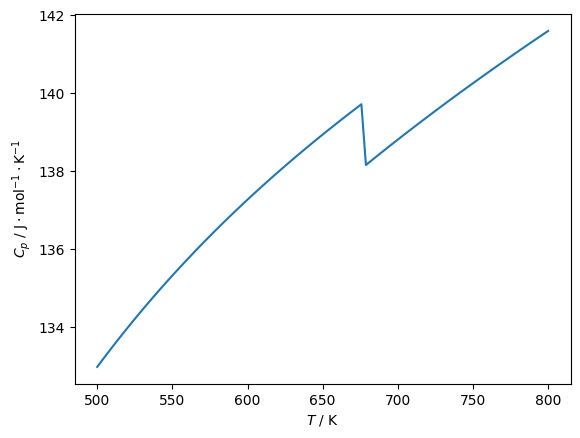

In [14]:
# which phase transitions are there in Sm2O3?..
# ..and plotting the heat capacity of Sm2O3 around the phase transition
db['Sm2O3'].table(transitions_only = True)
db['Sm2O3'].plot('cp', 500, 800)

In [15]:
# what is the enthalpy increment of Y2O3 between some temperatures?
db['Y2O3'].h(933.48) - db['Y2O3'].h(298.15)

76811.62541647768

In [16]:
# tabulating the thermodynamics of Gd2O3
db['Gd2O3'].table(300, 1600, 100)

Compound: Gd2O3
Formula: Gd2O3
Compound 'Gd2O3' contains 2 phases: C (solid), B (solid)

Standard state transitions at 1 atm (per mol):
_______	________	________	____________	________	________
  Trans	    T(K)	    T(C)	       ΔH(J)	 ΔS(J/K)	ΔCp(J/K)
_______	________	________	____________	________	________
 C -> B	 1424.84	 1151.69	      5324.6	   3.737	  -2.226

Phase: stable
State: solid
________	________	___________	___________	________	___________
  T(K)  	Cp(J/K) 	    H(J)   	   G(J)    	 S(J/K) 	 H-H298(J)
________	________	___________	___________	________	___________
  298.15	 105.639	 -1827530.9	 -1872434.0	 150.606	        0.0
  300.00	 105.876	 -1827335.3	 -1872713.3	 151.260	      195.7
  400.00	 114.669	 -1816254.4	 -1889485.4	 183.078	    11276.5
  500.00	 119.431	 -1804530.1	 -1909140.0	 209.220	    23000.8
  600.00	 122.606	 -1792419.7	 -1931194.3	 231.291	    35111.2
  700.00	 125.031	 -1780033.5	 -1955299.2	 250.380	    47497.4
  800.00	 127.057	 -1767426.6	 -1981195.2	

In [17]:
# getting the symbolic functions for Cp of Gd2O3...
db['Gd2O3'].symbolic.cp

Piecewise((0.012876*T + 119.1688 - 1544000.0/T**2, T <= 1424.83901765472), (0.014406*T + 114.534 - 1080000.0/T**2, True))

In [18]:
# ...and for the constituting phases
db['Gd2O3']['C'].symbolic.cp

0.012876*T + 119.1688 - 1544000.0/T**2

In [19]:
db['Gd2O3']['B'].symbolic.cp

0.014406*T + 114.534 - 1080000.0/T**2

In [20]:
# getting the entropy of La2O3 for a number of temperatures in a numpy array
temps = np.arange(300, 720, 20)
sLa2O3 = db['La2O3'].s(temps)
print('T / K\tS / (J/mol/K)')
for t, s in zip(temps, sLa2O3):
    print(f'{t:.1f}\t{s:.2f}')

T / K	S / (J/mol/K)
300.0	128.05
320.0	135.16
340.0	141.94
360.0	148.44
380.0	154.66
400.0	160.63
420.0	166.36
440.0	171.87
460.0	177.19
480.0	182.31
500.0	187.25
520.0	192.03
540.0	196.65
560.0	201.13
580.0	205.48
600.0	209.69
620.0	213.79
640.0	217.77
660.0	221.65
680.0	225.42
700.0	229.10
